# Processing LAPD "calls for service" about fireworks

In [146]:
import json
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import numpy as np
import jenkspy
import altair as alt
from altair import datum
import altair_latimes as lat
pd.options.display.max_columns = 50
pd.set_option('display.max_colwidth', None)
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
alt.renderers.enable('default')

RendererRegistry.enable('default')

### Download latest "calls for service" and arrest/citation data

In [2]:
# %run 'download_calls.ipynb'
# %run './lapd-crimes/arrests/00-get-lapd-arrests-data.ipynb'

### Read processed arrest/citations data from LAPD

In [293]:
arrests = pd.read_csv('/Users/mhustiles/data/data/LA/Arrest_Data_from_2010_to_Present.csv', \
                 float_precision='round_trip', low_memory=False)

### Read processed 'calls for service' data from LAPD

In [288]:
df = pd.read_csv('/Users/mhustiles/data/data/LA/calls/la/los_angeles.csv', float_precision='round_trip', low_memory=False, dtype={'incident_number':str, 'area_occurred': str})

In [289]:
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'])
df['monthday'] = df['date'].dt.strftime('%m/%d')
df['year'] = df['date'].dt.strftime('%Y')

In [290]:
df['month'] = df['date'].dt.month
df['hour'] = df['time'].dt.hour

In [291]:
df['monthname'] = df['date'].dt.month_name()
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.day_name()

In [292]:
df['hourdisplay'] = df['time'].dt.strftime('%-I %p')

---

### Select only the 'calls' involving fireworks

In [111]:
fireworks = pd.DataFrame(df[df['call_type_description'] == 'FIREWORKS'])

In [112]:
fireworks.head()

index   incident_number reporting_district area_occurred call_type_code  \
399     399  PD20010100003822         Hollenbeck          0406           507F   
872     872  PD20010200000080          Southeast          1851           507F   
2999   2999  PD20010100000062          Southwest          0355           507F   
3145   3145  PD19123100005966           Van Nuys          0906           507F   
4149   4149  PD20012200005676            Topanga          2126           507F   

     call_type_description       date                time monthday  year  \
399              FIREWORKS 2020-01-01 2020-06-28 19:20:19    01/01  2020   
872              FIREWORKS 2020-01-02 2020-06-28 00:35:39    01/02  2020   
2999             FIREWORKS 2020-01-01 2020-06-28 00:18:16    01/01  2020   
3145             FIREWORKS 2020-01-01 2020-06-28 01:43:40    01/01  2020   
4149             FIREWORKS 2020-01-22 2020-06-28 20:43:30    01/22  2020   

      month  hour monthname  day    weekday hourdisplay  
399       1    19   January    1  Wednesday        7 PM  
872       1     0   January    2   Thursday       12 AM  
2999      1     0   January    1  Wednesday       12 AM  
3145      1     1   January    1  Wednesday        1 AM  
4149      1    20   January   22  Wednesday        8 PM

### Clean up dates

In [113]:
# fireworks['date'] = pd.to_datetime(fireworks['date'], format='%Y-%m-%d')
# fireworks['monthday'] = fireworks['date'].dt.strftime('%m/%d')
# fireworks['year'] = fireworks['date'].dt.strftime('%Y')

In [114]:
# fireworks['month'] = fireworks['date'].dt.month
# fireworks['monthname'] = fireworks['date'].dt.month_name()
# fireworks['day'] = fireworks['date'].dt.day
# fireworks['weekday'] = fireworks['date'].dt.day_name()

### What does out dataframe look like? 

In [119]:
fireworks.head()

index   incident_number reporting_district area_occurred call_type_code  \
399     399  PD20010100003822         Hollenbeck          0406           507F   
872     872  PD20010200000080          Southeast          1851           507F   
2999   2999  PD20010100000062          Southwest          0355           507F   
3145   3145  PD19123100005966           Van Nuys          0906           507F   
4149   4149  PD20012200005676            Topanga          2126           507F   

     call_type_description       date                time monthday  year  \
399              FIREWORKS 2020-01-01 2020-06-28 19:20:19    01/01  2020   
872              FIREWORKS 2020-01-02 2020-06-28 00:35:39    01/02  2020   
2999             FIREWORKS 2020-01-01 2020-06-28 00:18:16    01/01  2020   
3145             FIREWORKS 2020-01-01 2020-06-28 01:43:40    01/01  2020   
4149             FIREWORKS 2020-01-22 2020-06-28 20:43:30    01/22  2020   

      month  hour monthname  day    weekday hourdisplay  
399       1    19   January    1  Wednesday        7 PM  
872       1     0   January    2   Thursday       12 AM  
2999      1     0   January    1  Wednesday       12 AM  
3145      1     1   January    1  Wednesday        1 AM  
4149      1    20   January   22  Wednesday        8 PM

### How many fireworks records do we have? 

In [120]:
len(fireworks)

42220

## What time do fireworks calls happen? 

In [121]:
time_fireworks = fireworks[(fireworks['reporting_district'] != 'Outside') &\
                     (fireworks['year'] == '2020')].groupby(['hourdisplay', 'hour']).agg('size').reset_index(name='calls')

In [122]:
time_all = df[(df['reporting_district'] != 'Outside') &\
                     (df['year'] == '2020')].groupby(['hourdisplay', 'hour']).agg('size').reset_index(name='calls')

### Add labels for charting

In [123]:
time_fireworks['label'] = 'Fireworks calls'
time_all['label'] = 'All calls'
time_fireworks['hour'] = time_fireworks['hour'].astype(str)
time_fireworks['text'] = '545 calls'

### Chart the fireworks calls by hour

In [124]:
time_chart = alt.Chart(time_fireworks).mark_circle(
    color='#B32F2E',
    opacity=0.7,
    stroke='white',
    strokeWidth=0
).encode(
    alt.X('hourdisplay:N', sort=alt.SortField(field="hour", order='ascending'), \
          axis=alt.Axis(labelAngle=0, tickSize=0, domainOpacity=0, values=['12AM', '6AM', '3PM', '9PM']), title=''),
    alt.Y('label:N', axis=alt.Axis(offset=6,tickSize=0,domainOpacity=0), title=''),
    alt.Size('calls:Q',
        scale=alt.Scale(range=[0, 1500]),
        legend=None
    )
).properties(
    width=500,
    height=50,
    title='What time are fireworks complaints to LAPD?'
)

time_text_one = (
    alt.Chart(time_fireworks.query("calls == calls.max()"))
    .mark_text(dx=198,dy=-27, color="#000000", font='Benton Gothic', fontWeight='bolder', fontSize=11)
    .encode(text=alt.Text("text:N")).transform_calculate(text='"calls"')
)

time_text_two = (
    alt.Chart(time_fireworks.query("calls == calls.max()"))
    .mark_text(dx=198,dy=-39, color="#000000", font='Benton Gothic', fontWeight='bolder', fontSize=11)
    .encode(text=alt.Text("calls:N",format=''))
)

(time_chart + time_text_one + time_text_two).configure_view(strokeOpacity=0)

alt.LayerChart(...)

### How many fireworks 'calls' per day, on average?

In [125]:
daily = fireworks.groupby(['date', 'monthday']).agg('size').reset_index(name='calls')

In [126]:
daily_avg = daily.groupby(['monthday']).agg('mean').round(0).reset_index()

In [127]:
daily_avg.head(10)

monthday  calls
0    01/01   56.0
1    01/02    6.0
2    01/03    3.0
3    01/04    5.0
4    01/05    4.0
5    01/06    3.0
6    01/07    3.0
7    01/08    4.0
8    01/09    3.0
9    01/10    2.0

In [128]:
chart = alt.Chart((daily_avg))\
    .mark_bar(size=1,opacity=1, color='#B32F2E')\
    .encode(
    x=alt.X('monthday:T', title=' ', axis=alt.Axis(values=['07', '01', '12'], grid=False, tickCount=12, format='%B')),
    y=alt.Y('calls:Q', stack=None, title=' ', axis=alt.Axis(gridWidth=.6,\
     gridColor='#dddddd',offset=6,tickSize=0,domainOpacity=0,tickCount=2, format=''),\
           scale=alt.Scale(domain=(0, 750)))
).properties(width=700, height=100,
     title='Average daily fireworks calls to LAPD: 2010-2020'
)

chart.configure_view(strokeOpacity=0).configure_legend(
    orient='top',
    symbolType='stroke'
).configure_legend(symbolType='square')

alt.Chart(...)

### How many per month? 

In [147]:
monthly = fireworks[fireworks['reporting_district'] != 'Outside']\
    .groupby(['month', 'monthname', 'reporting_district']).agg('size').reset_index(name='calls')

In [148]:
monthly_average = monthly.groupby(['month','monthname','reporting_district'])['calls'].mean().round(0).reset_index()

In [149]:
chart = alt.Chart((monthly_average))\
    .mark_bar(size=6,opacity=.6, color='#B32F2E', interpolate='monotone')\
    .encode(
    x=alt.X('monthname:N', title=' ', sort=alt.SortField(field="month", order='ascending'), \
            axis=alt.Axis(values=['July'], grid=False, tickCount=1, format='')),
    y=alt.Y('calls:Q', stack=None, title=' ', axis=alt.Axis(gridWidth=.6,\
     gridColor='#dddddd',offset=6,tickSize=0,domainOpacity=0,tickCount=2, format=''),\
           scale=alt.Scale(domain=(0, 1500))),\
    facet=alt.Facet('reporting_district:N', columns=7, title=' ')
).properties(width=100, height=60,
     title='Average monthly fireworks calls to LAPD: 2010-2020'
)

chart.configure_view(strokeOpacity=0).configure_legend(
    orient='top',
    symbolType='stroke'
).configure_legend(symbolType='square')

alt.Chart(...)

### All fireworks calls, in all years, at this point of the year

In [150]:
districts = fireworks[(fireworks['reporting_district'] != 'Outside') &\
                     (fireworks['monthday'] < '06/23')].groupby(['year', 'reporting_district']).agg('size').reset_index(name='calls')

In [151]:
chart = alt.Chart((districts))\
    .mark_bar(size=6,opacity=.6, color='#B32F2E', interpolate='monotone')\
    .encode(
    x=alt.X('year:T', title=' ', axis=alt.Axis(grid=False, tickCount=1, format='%Y')),
    y=alt.Y('calls:Q', stack=None, title=' ', axis=alt.Axis(gridWidth=.6,\
     gridColor='#dddddd',offset=6,tickSize=0,domainOpacity=0,tickCount=1, format=''),\
           scale=alt.Scale(domain=(0, 250))),\
    facet=alt.Facet('reporting_district:N', columns=7, title=' ')
).properties(width=80, height=50,
     title='LAPD annual fireworks calls from Jan. 1 to June 23, by division'
)

chart.configure_view(strokeOpacity=0)

alt.Chart(...)

In [246]:
fireworks_trend = pd.DataFrame(df[df['call_type_code'] == '507F'])

In [266]:
each_day = fireworks_trend[fireworks_trend['year'] != '2020'].groupby(['monthday', 'reporting_district']).agg('size').reset_index(name='average')

In [267]:
each_day['average'] = each_day['average']/10

In [268]:
each_day.head()

monthday reporting_district  average
0    01/01        77th Street      0.8
1    01/01            Central      0.7
2    01/01         Devonshire      4.5
3    01/01           Foothill      4.4
4    01/01             Harbor      1.9

In [269]:
thisyear = fireworks_trend[fireworks_trend['year'] == '2020'].groupby(['monthday', 'reporting_district']).agg('size').reset_index(name='average')

In [270]:
thisyear.head()

monthday reporting_district  average
0    01/01        77th Street        2
1    01/01         Devonshire        4
2    01/01           Foothill        6
3    01/01             Harbor        4
4    01/01         Hollenbeck        1

In [271]:
fireworks_avg_now = each_day.merge(thisyear, on=['monthday', 'reporting_district'], how='left')

In [272]:
fireworks_avg_now.rename(columns={'reporting_district_x':'reporting_district', 'average_x':'Average 2010-2019', 'average_y':'ThisYear'}, inplace=True)

In [273]:
fireworks_avg_now.ThisYear = fireworks_avg_now.ThisYear.ffill()

In [274]:
fireworks_chart = pd.DataFrame(fireworks_avg_now[fireworks_avg_now['monthday'] < '06/20'])

In [275]:
fireworks_melt = pd.melt(fireworks_chart, id_vars=['monthday', 'reporting_district'], value_vars=['Average 2010-2019', 'ThisYear'],
        var_name='time', value_name='calls')

In [276]:
fireworks_melt.head()

monthday reporting_district               time  calls
0    01/01        77th Street  Average 2010-2019    0.8
1    01/01            Central  Average 2010-2019    0.7
2    01/01         Devonshire  Average 2010-2019    4.5
3    01/01           Foothill  Average 2010-2019    4.4
4    01/01             Harbor  Average 2010-2019    1.9

In [286]:
chart = alt.Chart((fireworks_melt))\
    .mark_bar(size=1,opacity=0.3)\
    .encode(
    x=alt.X('monthday:T', title=' ', axis=alt.Axis(grid=False, tickCount=6, format='%B')),
    y=alt.Y('calls:Q', stack=None, title=' ', axis=alt.Axis(gridWidth=.6,\
     gridColor='#dddddd',offset=6,tickSize=0,domainOpacity=0,tickCount=4, format=''),\
           scale=alt.Scale(domain=(0, 30))),
    color=alt.Color("time:N", title=' '),
    facet=alt.Facet('reporting_district:N', columns=7, title='')
).properties(width=100, height=100,
     title='Fireworks calls to LAPD'
)

(chart).configure_view(strokeOpacity=0).configure_legend(
    orient='top',
    symbolType='stroke'
).configure_legend(symbolType='square', orient='top')

alt.Chart(...)

---

## Geography

### All fireworks calls by district in 2020?

In [163]:
districts2020 = fireworks[(fireworks['reporting_district'] != 'Outside') &\
                     (fireworks['year'] == '2020')].groupby(['year', 'reporting_district']).agg('size').reset_index(name='calls')

### All calls by district?

In [164]:
districts_all_2020 = df[(df['reporting_district'] != 'Outside') &\
                     (df['year'] == '2020')].groupby(['year', 'reporting_district']).agg('size').reset_index(name='calls')

In [165]:
districts_all_2020.head()

year reporting_district  calls
0  2020        77th Street  33159
1  2020            Central  26132
2  2020         Devonshire  18407
3  2020           Foothill  19313
4  2020             Harbor  20057

### All calls by area? 

In [166]:
areas_all_2020 = df[(df['area_occurred'] != 'Outside') &\
                     (df['year'] == '2020')].groupby(['year', 'area_occurred']).agg('size').reset_index(name='calls')

In [167]:
areas2020 = fireworks[(fireworks['area_occurred'] != 'Outside') &\
                     (fireworks['year'] == '2020')].groupby(['year', 'area_occurred']).agg('size').reset_index(name='calls')

### Hack the 2020 fireworks and 'all calls' frames together

In [168]:
districts2020['all_calls'] = districts_all_2020['calls']

In [169]:
areas_2020_merge = areas_all_2020.merge(areas2020, on='area_occurred').rename(columns={'year_x': 'year', 'calls_x':'all_calls', 'calls_y':'fireworks_calls'}).drop(['year_y'], axis=1)

In [170]:
areas_2020_merge.head()

year area_occurred  all_calls  fireworks_calls
0  2020          0101        441                1
1  2020          0105        103                1
2  2020          0111       1958                2
3  2020          0147        553                1
4  2020          0154        682                1

#### What's the fireworks call rate per 1,000 calls? 

In [171]:
districts2020['rate'] = (districts2020['calls'] / (districts2020['all_calls'] / 1000)).round(2)

In [172]:
districts2020.head()

year reporting_district  calls  all_calls   rate
0  2020        77th Street    164      33159   4.95
1  2020            Central     14      26132   0.54
2  2020         Devonshire     86      18407   4.67
3  2020           Foothill    204      19313  10.56
4  2020             Harbor    187      20057   9.32

In [173]:
districts2020['aprec'] = districts2020['reporting_district'].str.upper()

In [174]:
areas_2020_merge['rate'] = (areas_2020_merge['fireworks_calls'] / (areas_2020_merge['all_calls'] / 1000)).round(2)

In [175]:
areas_2020_merge.head()

year area_occurred  all_calls  fireworks_calls  rate
0  2020          0101        441                1  2.27
1  2020          0105        103                1  9.71
2  2020          0111       1958                2  1.02
3  2020          0147        553                1  1.81
4  2020          0154        682                1  1.47

In [176]:
areas_2020_merge['area_occurred'] = areas_2020_merge['area_occurred'].astype(str)

### Set proper breaks for mapping, first the LAPD divisions

In [177]:
districts_breaks = jenkspy.jenks_breaks(list(districts2020.rate), nb_class=7)
districts_breaks

[0.54, 1.69, 3.16, 4.67, 5.3, 7.64, 9.32, 10.56]

In [178]:
def get_group_districts(value):
    for i, b in enumerate(districts_breaks):
        if value <= districts_breaks[i+1]:
            return i

In [179]:
districts2020['rate_group'] = districts2020.rate.apply(get_group_districts)

In [180]:
districts2020.sort_values(by='rate_group', ascending=False).head()

year reporting_district  calls  all_calls   rate       aprec  rate_group
3   2020           Foothill    204      19313  10.56    FOOTHILL           6
7   2020            Mission    234      22265  10.51     MISSION           6
4   2020             Harbor    187      20057   9.32      HARBOR           5
10  2020          Northeast    158      20674   7.64   NORTHEAST           4
5   2020         Hollenbeck    141      19982   7.06  HOLLENBECK           4

#### Areas...

In [181]:
areas_breaks = jenkspy.jenks_breaks(list(areas_2020_merge.rate), nb_class=7)
areas_breaks

[0.45, 5.39, 9.97, 15.04, 21.74, 35.04, 50.0, 70.51]

In [182]:
def get_group_areas(value):
    for i, b in enumerate(areas_breaks):
        if value <= areas_breaks[i+1]:
            return i

In [183]:
areas_2020_merge['rate_group'] = areas_2020_merge.rate.apply(get_group_areas)

In [184]:
areas_2020_merge.sort_values(by='rate_group', ascending=False).head()

year area_occurred  all_calls  fireworks_calls   rate  rate_group
479  2020          1633        407               23  56.51           6
421  2020          1468        156               11  70.51           6
214  2020          0821        106                4  37.74           5
662  2020          2104        225               11  48.89           5
90   2020          0414         87                4  45.98           5

---

#### Read LA Times neighborhoods boundaries

In [185]:
hoods = gpd.read_file('/Users/mhustiles/data/data/GIS/LA/neighborhoods/custom-la-hoods-skid-row.geojson')

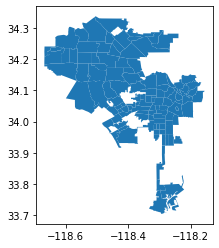

In [186]:
hoods.plot()

#### Read the more granular LAPD 'reporting districts' boundary file

In [187]:
areas_geo = gpd.read_file('/Users/mhustiles/data/data/GIS/lapd/output/LAPD_Reporting_Districts.json')

#### Areas centroids

In [188]:
areas_geo['centroid_x'] = areas_geo.geometry.centroid.x
areas_geo['centroid_y'] = areas_geo.geometry.centroid.y

### Clean up headers and data types

In [189]:
areas_geo.columns = areas_geo.columns.str.strip().str.lower().str.replace(' ','_')\
    .str.replace('(', '').str.replace(')', '').str.replace('/','_')

In [190]:
areas_geo['repdist'] = areas_geo['repdist'].astype(str)

#### Read the larger LAPD divisions geography file

In [191]:
divisions_geo = gpd.read_file('/Users/mhustiles/data/data/GIS/lapd/LAPD_Divisions-shp/LAPD_Divisions.shp')

#### Divisions centroids

In [192]:
divisions_geo['centroid_x'] = divisions_geo.geometry.centroid.x
divisions_geo['centroid_y'] = divisions_geo.geometry.centroid.y

#### Clean up headers and data ahead of merge

In [193]:
divisions_geo.columns = divisions_geo.columns.str.strip().str.lower().str.replace(' ','_')\
    .str.replace('(', '').str.replace(')', '').str.replace('/','_')

In [194]:
divisions_geo.loc[divisions_geo.aprec == 'WEST LOS ANGELES', 'aprec'] = 'WEST LA'
divisions_geo.loc[divisions_geo.aprec == 'NORTH HOLLYWOOD', 'aprec'] = 'N HOLLYWOOD'

#### Merge fireworks aggregates with divisions boundaries

In [195]:
fireworks_divisions_geo = gpd.GeoDataFrame(districts2020.merge(divisions_geo, on='aprec', how='left'))

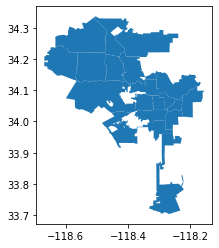

In [196]:
fireworks_divisions_geo.plot()

#### Export fireworks rate by division

In [197]:
fireworks_divisions_geo.to_file('output/fireworks_divisions_geo.geojson', driver='GeoJSON')

#### Merge reporting districts boundaries with fireworks aggregates

In [198]:
areas_geo['repdist'] = areas_geo['repdist'].str.zfill(4)

#### Export fireworks rate by reporting districts boundaries 

In [199]:
areas_geo_merge = gpd.GeoDataFrame(areas_geo.merge(areas_2020_merge, left_on='repdist', right_on='area_occurred', how='left'))

In [200]:
areas_geo_merge[['repdist', 'prec', 'aprec', 'bureau', 'basiccar', 'area', 'perimeter', 'shape_leng', 'shape_area','year', 'area_occurred', \
                 'all_calls', 'fireworks_calls', 'rate', 'rate_group','geometry', 'centroid_x', 'centroid_y']] = \
areas_geo_merge[['repdist', 'prec', 'aprec', 'bureau', 'basiccar', 'area', 'perimeter', 'shape_leng', 'shape_area','year', 'area_occurred', \
                 'all_calls', 'fireworks_calls', 'rate', 'rate_group', 'geometry', 'centroid_x', 'centroid_y']]

In [201]:
areas_geo_merge.to_file('output/areas_geo_merge.geojson', driver='GeoJSON')

---

## Map the calls

#### Convert divisions dataframe to json for Altair

In [202]:
hoods_geojson = json.loads(hoods.to_json())
hoods_features = alt.Data(values=hoods_geojson['features'])

In [203]:
divisions_geojson = json.loads(fireworks_divisions_geo.to_json())
divisions_features = alt.Data(values=divisions_geojson['features'])

#### Make the base map

In [204]:
base = alt.Chart(divisions_features).mark_geoshape(
    stroke='white',
    strokeWidth=0.1
).encode().properties(
    width=600,
height=800)

#### Make the fill layers

In [205]:
geoshape = alt.Chart(divisions_features).mark_geoshape(
    stroke='white'
)

In [206]:
fireworks_divisions = geoshape.encode(
    color=alt.Color(
        "properties.rate_group:N",
        scale=alt.Scale(
            domain=[0, 1, 2, 3, 4, 5, 6],
            range=lat.palette['schemes']['fire-7']
        ),
        legend=None
    ),
)

In [207]:
(base + fireworks_divisions).properties(title="Fireworks calls by LAPD division in 2020").configure_view(
    strokeWidth=0
)

alt.LayerChart(...)

#### Plot the LAPD areas a.k.a. "reporting districts"

In [208]:
areas_geojson = json.loads(areas_geo_merge.to_json())
areas_features = alt.Data(values=areas_geojson['features'])

In [209]:
areas_base = alt.Chart(areas_features).mark_geoshape(
    fill='#e6e6e6',
    stroke='white',
    strokeWidth=0.01
).encode().properties(
    width=600, height=800)

In [210]:
areas_geoshape = alt.Chart(areas_features).mark_geoshape(
    stroke='white'
)

In [211]:
areas_features_map = areas_geoshape.encode(
    color=alt.Color(
        "properties.rate_group:N",
        scale=alt.Scale(
            domain=[0, 1, 2, 3, 4, 5, 6],
            range=lat.palette['schemes']['fire-7']
        ),
        legend=None
    ),
)

In [212]:
(areas_base + areas_features_map).properties(title="Fireworks calls by LAPD reporting district in 2020").configure_view(
    strokeWidth=0
)

alt.LayerChart(...)